**Load Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
sns.set()


**Load and Examine the Dataset**

In [2]:
train_data = pd.read_csv('/kaggle/input/umojahack-2023-beginner-practice-challenge/Train.csv')

print(train_data.head())
print(train_data.info())
print(train_data.describe())
print(train_data.isnull().sum())


        Place_ID X Date        Date Place_ID  target  target_min  target_max  \
0  010Q650 X 2020-01-02  2020-01-02  010Q650    38.0        23.0        53.0   
1  010Q650 X 2020-01-03  2020-01-03  010Q650    39.0        25.0        63.0   
2  010Q650 X 2020-01-04  2020-01-04  010Q650    24.0         8.0        56.0   
3  010Q650 X 2020-01-05  2020-01-05  010Q650    49.0        10.0        55.0   
4  010Q650 X 2020-01-06  2020-01-06  010Q650    21.0         9.0        52.0   

   target_variance  target_count  precipitable_water_entire_atmosphere  \
0           769.50            92                             11.000000   
1          1319.85            91                             14.600000   
2          1181.96            96                             16.400000   
3          1113.67            96                              6.911948   
4          1164.82            95                             13.900001   

   relative_humidity_2m_above_ground  ...  L3_SO2_sensor_zenith_angle  \
0

**Handle Missing Values and Feature Engineering**
* Fill Missing Values: For simplicity, we will fill numerical missing values with the median

* Date Handling: Extract year, month, and day from the 'Date' column for possible use as features.

* Drop Unnecessary Columns: Since 'Place_ID X Date' and 'Place_ID' might not be useful for modeling directly, we'll drop them.

In [3]:
train_data = pd.read_csv('/kaggle/input/umojahack-2023-beginner-practice-challenge/Train.csv')

# Convert 'Date' to datetime if it's still in the DataFrame
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Extracting Year, Monthand Day from the 'Date' column
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day

# Dropping the 'Date' column after extraction
train_data.drop('Date', axis=1, inplace=True)

# Filling missing values by creating a copy to modify directly 
for col in train_data.columns:
    if train_data[col].dtype == 'float64':
        train_data[col] = train_data[col].fillna(train_data[col].median())

print(train_data.head())


        Place_ID X Date Place_ID  target  target_min  target_max  \
0  010Q650 X 2020-01-02  010Q650    38.0        23.0        53.0   
1  010Q650 X 2020-01-03  010Q650    39.0        25.0        63.0   
2  010Q650 X 2020-01-04  010Q650    24.0         8.0        56.0   
3  010Q650 X 2020-01-05  010Q650    49.0        10.0        55.0   
4  010Q650 X 2020-01-06  010Q650    21.0         9.0        52.0   

   target_variance  target_count  precipitable_water_entire_atmosphere  \
0           769.50            92                             11.000000   
1          1319.85            91                             14.600000   
2          1181.96            96                             16.400000   
3          1113.67            96                              6.911948   
4          1164.82            95                             13.900001   

   relative_humidity_2m_above_ground  specific_humidity_2m_above_ground  ...  \
0                          60.200001                            0.

**Setting Up and Running OLS Regression**
* Import necessary modules: You'll need statsmodels.api to access the OLS model.
* Create the model: Define your dependent variable (target) and independent variables (all other columns except Place_ID and Place_ID X Date which might be non-predictive identifiers).
* Fit the model: Fit your model to the training data to learn the coefficients.
* Summary output: Review the summary output from the model to understand the coefficient values, statistical significance, and model diagnostics.

In [4]:
X = train_data.drop(['Place_ID X Date', 'Place_ID', 'target'], axis=1)
y = train_data['target']
# Adding a constant to the model (intercept)
X = sm.add_constant(X)

model = sm.OLS(y, X)

results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     1552.
Date:                Thu, 17 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:59:42   Log-Likelihood:            -1.3610e+05
No. Observations:               30557   AIC:                         2.724e+05
Df Residuals:                   30476   BIC:                         2.730e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

** Filter Numeric Columns for Correlation Calculation**

In [5]:
# Select only numeric columns for correlation calculation
numeric_cols = train_data.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

# Optionally, find features with a correlation greater than 0.8 (high correlation)
high_corr = corr_matrix[corr_matrix.abs() > 0.8]
print(high_corr)


                              target  target_min  target_max  target_variance  \
target                      1.000000    0.818803         NaN              NaN   
target_min                  0.818803    1.000000         NaN              NaN   
target_max                       NaN         NaN         1.0              NaN   
target_variance                  NaN         NaN         NaN              1.0   
target_count                     NaN         NaN         NaN              NaN   
...                              ...         ...         ...              ...   
L3_CH4_solar_azimuth_angle       NaN         NaN         NaN              NaN   
L3_CH4_solar_zenith_angle        NaN         NaN         NaN              NaN   
Year                             NaN         NaN         NaN              NaN   
Month                            NaN         NaN         NaN              NaN   
Day                              NaN         NaN         NaN              NaN   

                           

**Diagnosing Multicollinearity**
* Calculate the correlation matrix to identify highly correlated variables.
* Remove or combine features that are highly correlated to reduce multicollinearity.

In [6]:
numeric_cols = train_data.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()
print(corr_matrix)

# identify pairs of highly correlated features 
high_corr_vars = np.where(np.abs(corr_matrix) > 0.8)
high_corr_pairs = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_vars) if x != y and x < y]
print("Highly correlated pairs:", high_corr_pairs)


                              target  target_min  target_max  target_variance  \
target                      1.000000    0.818803    0.630801         0.184818   
target_min                  0.818803    1.000000    0.421529         0.047010   
target_max                  0.630801    0.421529    1.000000         0.500524   
target_variance             0.184818    0.047010    0.500524         1.000000   
target_count                0.094135   -0.065336    0.163211        -0.013280   
...                              ...         ...         ...              ...   
L3_CH4_solar_azimuth_angle -0.119346   -0.102292   -0.088815        -0.033887   
L3_CH4_solar_zenith_angle   0.093706    0.085082    0.065816         0.023956   
Year                             NaN         NaN         NaN              NaN   
Month                      -0.122800   -0.119445   -0.092465        -0.008608   
Day                         0.005238    0.011662    0.002669        -0.000748   

                           

**Identify and Remove Highly Correlated Features**

In [6]:
# List of features to remove based on high correlation analysis
features_to_remove = ['target_min', 'L3_NO2_NO2_slant_column_number_density', 'L3_NO2_tropospheric_NO2_column_number_density', 'L3_O3_sensor_azimuth_angle', 'L3_CO_sensor_azimuth_angle', 'L3_HCHO_sensor_azimuth_angle', 'L3_CLOUD_sensor_azimuth_angle', 'L3_AER_AI_sensor_azimuth_angle', 'L3_SO2_sensor_azimuth_angle', 'L3_O3_sensor_zenith_angle', 'L3_CLOUD_sensor_zenith_angle', 'L3_AER_AI_sensor_zenith_angle', 'L3_SO2_sensor_zenith_angle', 'L3_CLOUD_cloud_base_pressure', 'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure', 'L3_CH4_aerosol_height', 'L3_CH4_sensor_zenith_angle', 'L3_CH4_solar_azimuth_angle', 'L3_CH4_solar_zenith_angle']

# Remove these features from the dataset
train_data_reduced = train_data.drop(columns=features_to_remove)

# Verify the shape of the new dataset
print(train_data_reduced.shape)


(30557, 64)


**Reassess the Model:**

In [7]:

# Dropping highly correlated features from 'X'
features_to_remove = ['target_min', 'L3_NO2_NO2_slant_column_number_density', 'L3_NO2_tropospheric_NO2_column_number_density', 'L3_O3_sensor_azimuth_angle', 'L3_CO_sensor_azimuth_angle', 'L3_HCHO_sensor_azimuth_angle', 'L3_CLOUD_sensor_azimuth_angle', 'L3_AER_AI_sensor_azimuth_angle', 'L3_SO2_sensor_azimuth_angle', 'L3_O3_sensor_zenith_angle', 'L3_CLOUD_sensor_zenith_angle', 'L3_AER_AI_sensor_zenith_angle', 'L3_SO2_sensor_zenith_angle', 'L3_CLOUD_cloud_base_pressure', 'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure', 'L3_CH4_aerosol_height', 'L3_CH4_sensor_zenith_angle', 'L3_CH4_solar_azimuth_angle', 'L3_CH4_solar_zenith_angle']
X_reduced = X.drop(columns=features_to_remove)

# Ensure 'y' is aligned with 'X_reduced'; since no rows are removed, 'y_reduced' can be the same as 'y'
y_reduced = y.copy()

# Check data types to identify non-numeric columns
print(X_reduced.dtypes)

# Convert any non-numeric columns to numeric, handling errors
X_reduced = X_reduced.apply(pd.to_numeric, errors='coerce')

# Check for any remaining non-convertible types and fill NaNs created during conversion
X_reduced.fillna(0, inplace=True)

# Adding a constant to the model for the intercept
X_reduced = sm.add_constant(X_reduced)

# Create and fit the OLS model
model_reduced = sm.OLS(y_reduced, X_reduced)
results_reduced = model_reduced.fit()

# Print the model's summary
print(results_reduced.summary())


target_max                              float64
target_variance                         float64
target_count                              int64
precipitable_water_entire_atmosphere    float64
relative_humidity_2m_above_ground       float64
                                         ...   
L3_CH4_aerosol_optical_depth            float64
L3_CH4_sensor_azimuth_angle             float64
Year                                      int32
Month                                     int32
Day                                       int32
Length: 61, dtype: object
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     636.9
Date:                Thu, 17 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:03:37   Log-Likelih

**Addressing Remaining Multicollinearity**
1. Using VIF (Variance Inflation Factor) to systematically remove highly collinear variables.
2. Dimensionality Reduction: Apply PCA not merely as a diagnostic tool but integrate it into your model to reduce feature space while retaining most variability.

In [8]:
# Calculate VIF for each explanatory variable
vif_data = pd.DataFrame()
vif_data["feature"] = X_reduced.columns
vif_data["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))


                                 feature            VIF
58                                  Year  219899.988409
42           L3_CLOUD_solar_zenith_angle     117.022033
23              L3_O3_solar_zenith_angle      94.638358
41          L3_CLOUD_solar_azimuth_angle      63.377929
21                  L3_O3_cloud_fraction      63.024479
..                                   ...            ...
60                                   Day       1.232700
2                           target_count       1.195818
7   u_component_of_wind_10m_above_ground       1.164180
8   v_component_of_wind_10m_above_ground       1.158545
57           L3_CH4_sensor_azimuth_angle       1.117688

[61 rows x 2 columns]


In [9]:
# List of columns with high VIF to be dropped
high_vif_columns = [
    'Year', 'L3_CLOUD_solar_zenith_angle', 'L3_O3_solar_zenith_angle',
    'L3_CLOUD_solar_azimuth_angle', 'L3_O3_cloud_fraction'
]

X_vif_reduced = X_reduced.drop(columns=high_vif_columns)
X_vif_reduced = sm.add_constant(X_vif_reduced)

model_vif_reduced = sm.OLS(y_reduced, X_vif_reduced)
results_vif_reduced = model_vif_reduced.fit()

print(results_vif_reduced.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     681.6
Date:                Thu, 17 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:03:58   Log-Likelihood:            -1.4852e+05
No. Observations:               30557   AIC:                         2.971e+05
Df Residuals:                   30500   BIC:                         2.976e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [10]:
# Prepare the reduced dataset (the one after removing high VIF columns)
X_reduced = X_vif_reduced  
y = y_reduced  

# Step 1: Initialize models for further evaluation and comparison
models = {
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.1, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Step 2: Evaluate each model using cross-validation and calculate mean R-squared scores
for model_name, model in models.items():
    scores = cross_val_score(model, X_reduced, y, cv=5, scoring='r2')
    print(f"{model_name} Cross-Validation R-squared scores: {scores}")
    print(f"Mean {model_name} Cross-Validation R-squared: {np.mean(scores)}\n")


Ridge Regression Cross-Validation R-squared scores: [0.42621998 0.45512465 0.38852552 0.5555838  0.52038825]
Mean Ridge Regression Cross-Validation R-squared: 0.46916844423909615

Lasso Regression Cross-Validation R-squared scores: [0.40264077 0.42888132 0.34667809 0.52656306 0.4973937 ]
Mean Lasso Regression Cross-Validation R-squared: 0.44043138784987984

Random Forest Cross-Validation R-squared scores: [0.69723075 0.75312947 0.78167518 0.84144981 0.78706629]
Mean Random Forest Cross-Validation R-squared: 0.7721102984431643

XGBoost Cross-Validation R-squared scores: [0.69864643 0.76926443 0.78924528 0.84391899 0.78872771]
Mean XGBoost Cross-Validation R-squared: 0.7779605678789425



In [11]:
# Fit XGBoost model on the training data
xgboost_model = XGBRegressor(n_estimators=100, random_state=42)
xgboost_model.fit(X_reduced, y)

# Make predictions on the training data
predictions = xgboost_model.predict(X_reduced)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)

print(f"XGBoost Training Mean Squared Error: {mse}")
print(f"XGBoost Training R-squared: {r2}")


XGBoost Training Mean Squared Error: 106.0227596591394
XGBoost Training R-squared: 0.9517180847576407


In [12]:
import pickle

# Save the model to a file
model_filename = 'xgboost_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(xgboost_model, file)

print(f"Model saved to {model_filename}")


Model saved to xgboost_model.pkl


In [13]:
# Load the model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)


**Visualisation**

In [16]:
print(train_data.columns)


Index(['Place_ID X Date', 'Place_ID', 'target', 'target_min', 'target_max',
       'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
       'L3_

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create 'Date' column from the 'Year', 'Month', and 'Day' columns
train_data['Date'] = pd.to_datetime(train_data[['Year', 'Month', 'Day']])

# Verify the creation of the 'Date' column
print(train_data['Date'].head())


0   2020-01-02
1   2020-01-03
2   2020-01-04
3   2020-01-05
4   2020-01-06
Name: Date, dtype: datetime64[ns]


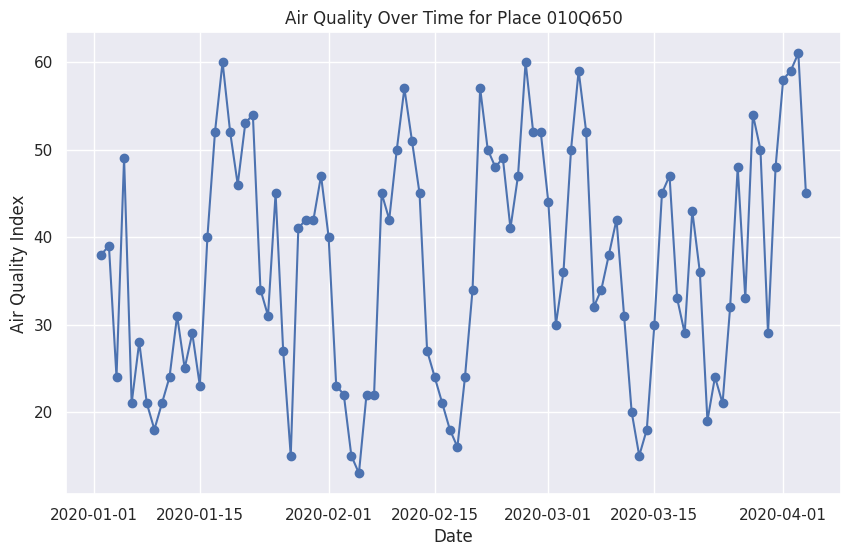

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


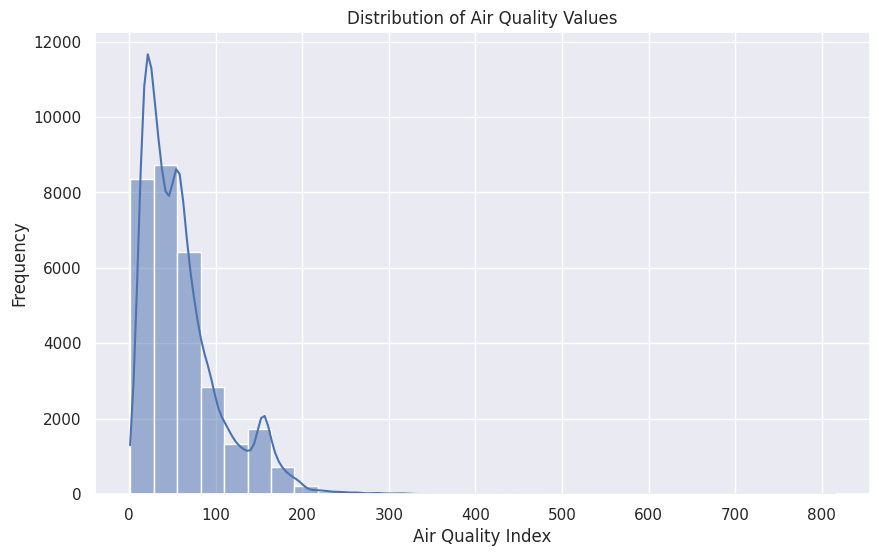

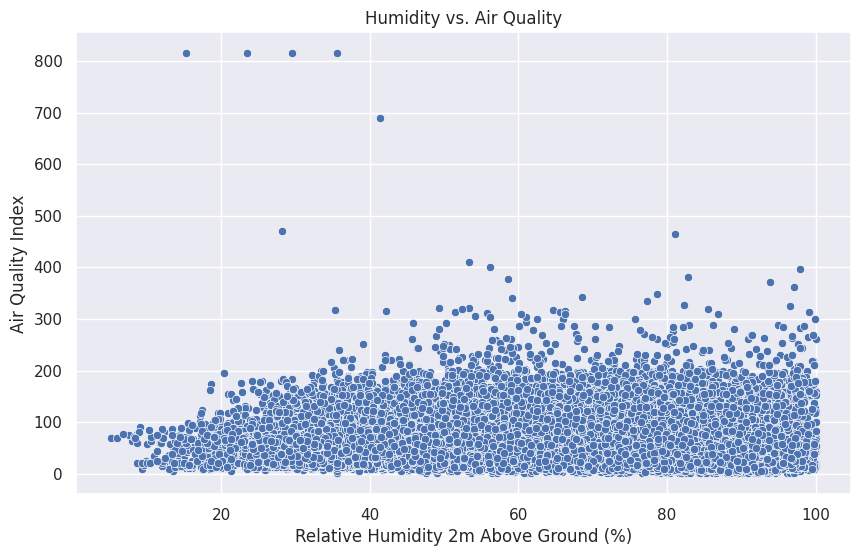

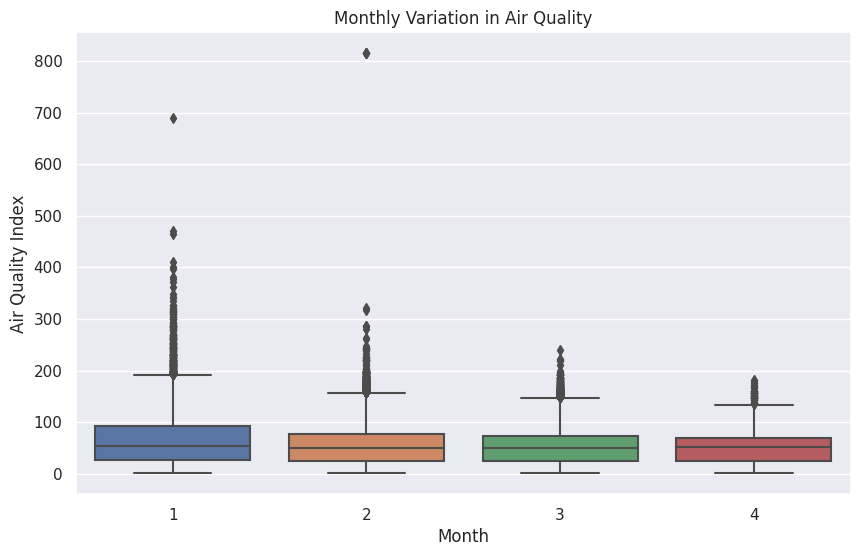

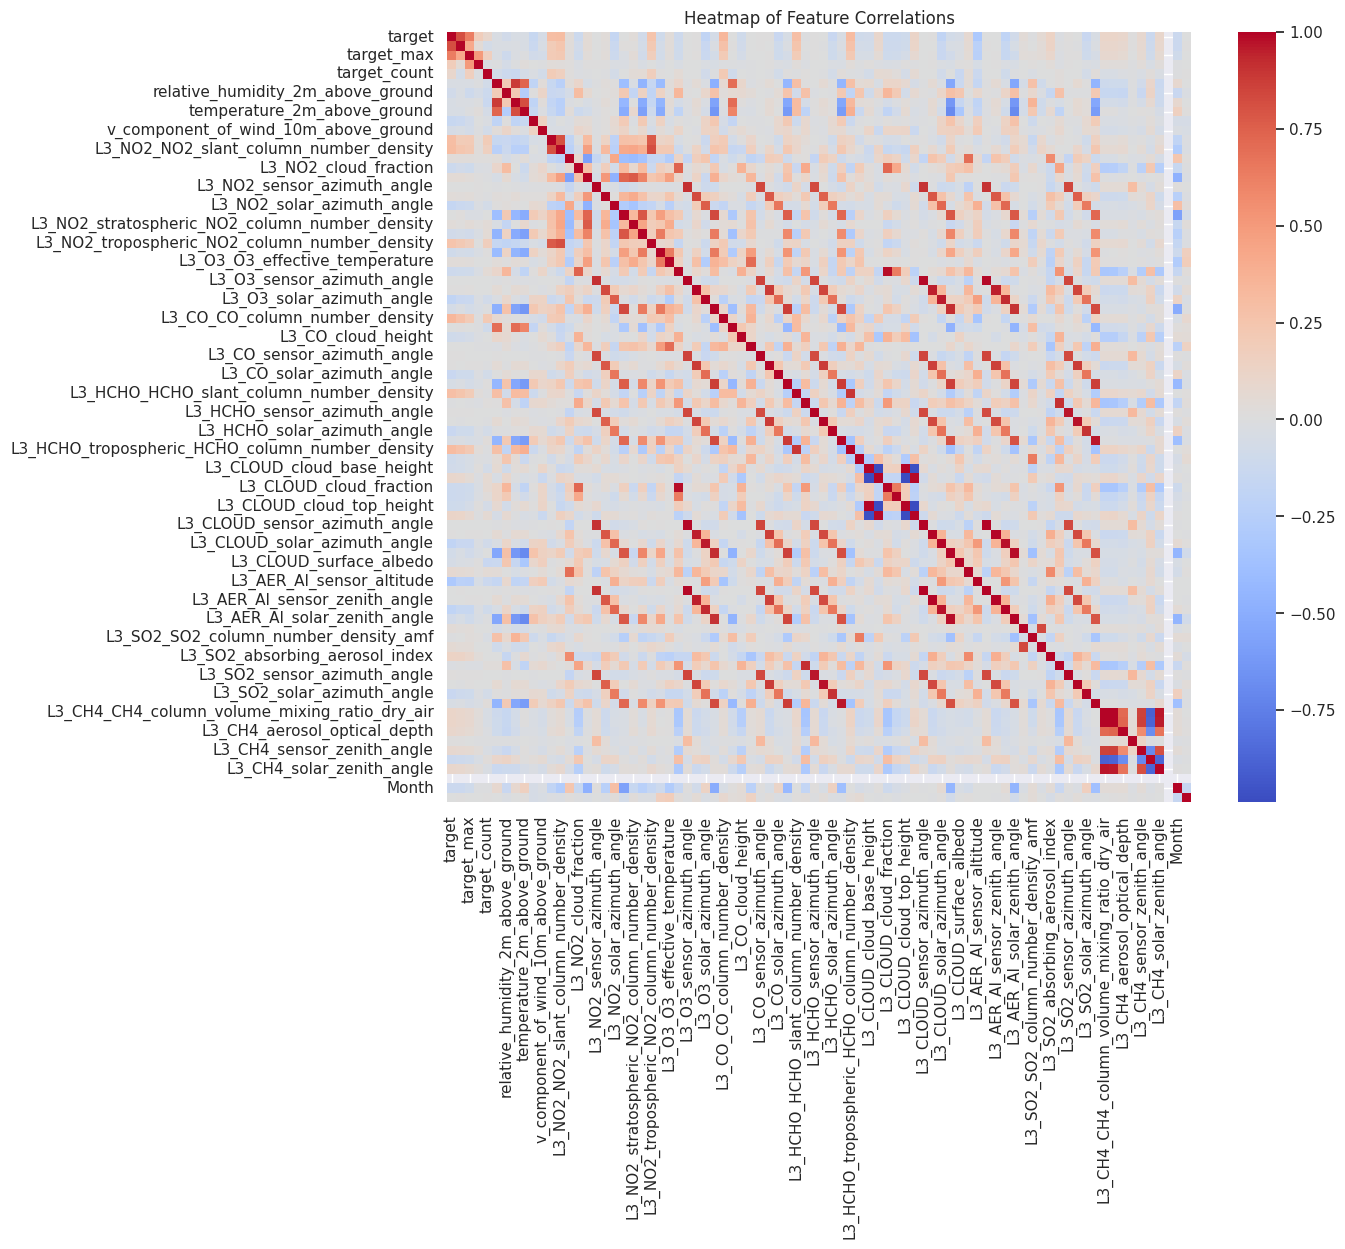

In [18]:
# Time Series Plot of Air Quality
plt.figure(figsize=(10, 6))
sample_location = train_data[train_data['Place_ID'] == '010Q650']  # Example location
plt.plot(sample_location['Date'], sample_location['target'], marker='o')
plt.title('Air Quality Over Time for Place 010Q650')
plt.xlabel('Date')
plt.ylabel('Air Quality Index')
plt.grid(True)
plt.savefig('time_series_aqi.png')
plt.show()

# Histogram of Air Quality Values
plt.figure(figsize=(10, 6))
sns.histplot(train_data['target'], bins=30, kde=True)
plt.title('Distribution of Air Quality Values')
plt.xlabel('Air Quality Index')
plt.ylabel('Frequency')
plt.savefig('aqi_histogram.png')
plt.show()

# Scatter Plot of Humidity vs. Air Quality
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='relative_humidity_2m_above_ground', y='target')
plt.title('Humidity vs. Air Quality')
plt.xlabel('Relative Humidity 2m Above Ground (%)')
plt.ylabel('Air Quality Index')
plt.savefig('humidity_vs_aqi.png')
plt.show()

# Box Plot of Air Quality by Month
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='target', data=train_data)
plt.title('Monthly Variation in Air Quality')
plt.xlabel('Month')
plt.ylabel('Air Quality Index')
plt.savefig('monthly_aqi_variation.png')
plt.show()

# Heatmap of Correlation Among Features
plt.figure(figsize=(12, 10))
correlation_matrix = train_data.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Heatmap of Feature Correlations')
plt.savefig('feature_correlations.png')
plt.show()
